In [52]:
import numpy as np
import pandas as pd
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from soyclustering import SphericalKMeans
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

---

# 1. Data load and preprocessing

In [2]:
data = pd.read_csv('../data/2019-2020.csv')
data.head()

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,Affiliations,Authors with affiliations,Abstract,Author Keywords,Index Keywords,Document Type,Publication Stage,Open Access,Source,EID
0,"Choi D.Y., Oh J.H., Kim J.K., Lee S.E.",57221531822;57193057094;57193067620;55857982000;,Energy efficient and low-cost server architect...,2020,KSII Transactions on Internet and Information ...,14,12,NaN,4648,4663,...,"Department of Electronic Engineering, Seoul Na...","Choi, D.Y., Department of Electronic Engineeri...",This paper proposes the Lempel-Ziv 4(LZ4) comp...,Data Compression; Hadoop Storage; Hardware Acc...,Acceleration; Costs; Digital storage; Energy e...,Article,Final,NaN,Scopus,2-s2.0-85099378902
1,"Ji J., Chung Y., Kwon Y.",57195592309;56984923500;7403457084;,The effects of cobalt phthalocyanine and polya...,2020,Journal of Power Sources,480,NaN,228860,NaN,NaN,...,"Graduate School of Energy and Environment, Seo...","Ji, J., Graduate School of Energy and Environm...",A catalyst capable of high performance and goo...,Cobalt phthalocyanine; H2O2 fuel cell; Hydroge...,Cobalt; Fuel cells; Graphene; Hydrogen peroxid...,Article,Final,NaN,Scopus,2-s2.0-85090334414
2,"Nguyen X.T., Nguyen T.N., Lee H.-J., Kim H.",57197875076;57210219943;8161276300;34770344200;,An accurate weight binarization scheme for CNN...,2020,IEIE Transactions on Smart Processing and Comp...,9,6,NaN,497,503,...,Department of Electrical and Computer Engineer...,"Nguyen, X.T., Department of Electrical and Com...","Recently, convolutional neural network (CNN)-b...",Binarization; Binary weight; Object detector; ...,NaN,Article,Final,NaN,Scopus,2-s2.0-85105278542
3,"Nov L., Chung J.-Y.",57222570971;56681595800;,Dielectric property characterisation of thin f...,2020,"IET Science, Measurement and Technology",14,10,NaN,992,996,...,"Department of Integrated IT Engineering, Seoul...","Nov, L., Department of Integrated IT Engineeri...",A new research on characterising the dielectri...,NaN,Coplanar waveguides; Dielectric properties of ...,Article,Final,NaN,Scopus,2-s2.0-85103300884
4,"Karunakaran G., Cho E.-B., Kumar G.S., Kolesni...",55480032500;7202649980;55430366400;57057275500...,Mesoporous Mg-doped hydroxyapatite nanorods pr...,2020,Ceramics International,46,18,NaN,28514,28527,...,"Biosensor Research Institute, Department of Fi...","Karunakaran, G., Biosensor Research Institute,...",The most important problem in post orthopedic ...,A; B; D. Apatite; E. Biomedical applications; ...,Crystal structure; Hydroxyapatite; Morphology;...,Article,Final,NaN,Scopus,2-s2.0-85089980054


In [3]:
with open('../data/embedding_vector.pickle', 'rb') as rf :
    vector = pickle.load(rf)

In [4]:
def text_preprocessing(data) :   
    with open('../stopwords/scientificstopwords.txt', 'r') as f :
        scientific_stopwords = f.readlines()
        scientific_stopwords = [word.strip() for word in scientific_stopwords]

    tokenized_english = []
    processed_data = []
    lemma = WordNetLemmatizer()
    final_stopwords = scientific_stopwords + stopwords.words('english')

    for _, corpus in enumerate(data) :
        tokenized_english.append(nltk.regexp_tokenize(corpus.lower(), '[A-Za-z]+'))

    for cor in tokenized_english :
        meaning_words = []
        for word in cor :
            if len(word) > 1 :
                if word not in final_stopwords :
                    meaning_words.append(lemma.lemmatize(word))
            
        processed_data.append(meaning_words)

    return processed_data

In [5]:
processed_data = text_preprocessing(data.Abstract)

In [7]:
tsne_vector = TSNE(n_components=2).fit_transform(vector)

---

# 2. Conduct clustering

## 2-1. KMeans clustering
- scikit-learn에서 제공하는 클러스터링 알고리즘을 사용하여 클러스터링 진행 
- 클러스터링 결과를 T-SNE로 시각화

In [10]:
kmeans = KMeans(n_clusters=30).fit(vector)
kmeans_clusters = kmeans.labels_

### 2-1-1. TSNE 시각화 

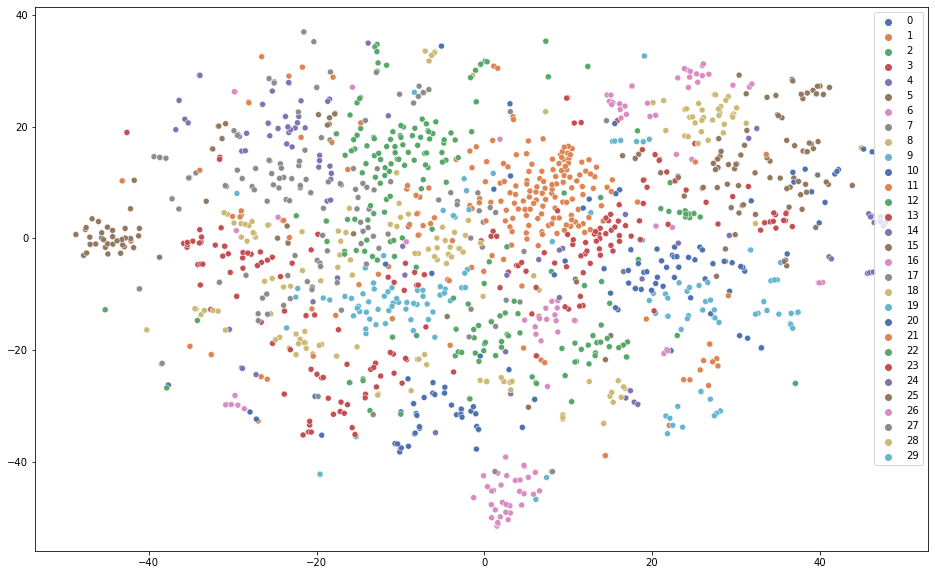

In [11]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(tsne_vector[:,0], tsne_vector[:,1], hue=kmeans_clusters, palette='deep', ax=ax)
plt.show()

- 클러스터별로 유사하게 묶이긴 하나 중간중간 다른 다른 클러스터에 침범한 데이터가 다수 보임 

### 2-1-2. 네트워크 내 클러스터 비중 

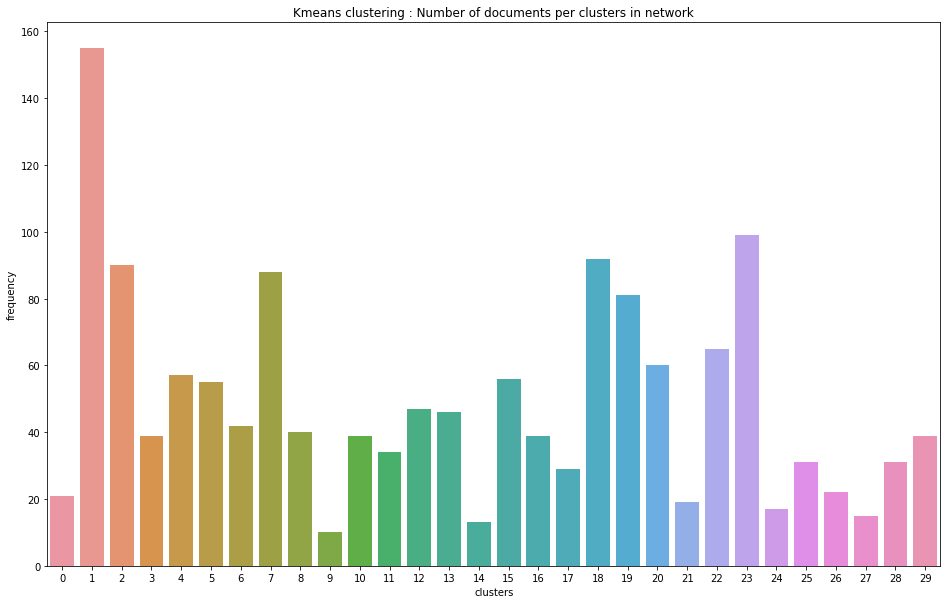

In [119]:
count_cluster = {i : kmeans_clusters.tolist().count(i) for i in range(30)}

fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x=list(count_cluster.keys()), y=list(count_cluster.values()), ax=ax)
plt.title('Kmeans clustering : Number of documents per clusters in network')
plt.xlabel('clusters')
plt.ylabel('frequency')
plt.show()

### 2-1-3. 클러스터 별 단어 분포 확인 

In [25]:
# 클러스터 별 abstract 추출 
abstract_per_cluster_kmeans = {idx : [] for idx in range(30)}
for idx, clus in enumerate(kmeans_clusters) :
    abstract_per_cluster_kmeans[clus].append(processed_data[idx])

In [103]:
def count_word_frequency(data) :
    clusters = list(data.keys())
    abstracts = list(data.values())
    output = {idx : None for idx in clusters}

    for idx in clusters :
        corpus = abstracts[idx]
        remove_duplicate_words = []

        for word_idx in range(len(corpus)) :
            unique_words = list(set(corpus[word_idx]))
            remove_duplicate_words += unique_words 

        output[idx] = pd.DataFrame(Counter(remove_duplicate_words), index=[0]).T.sort_values(by=[0], ascending=False)
        output[idx] = output[idx].set_axis(['frequency'], axis=1)
        output[idx]['clusters'] = [idx] * len(output[idx])
        output[idx] = output[idx][output[idx]['frequency'] >= 3] 

    

    return output

In [104]:
kmeans_result = count_word_frequency(abstract_per_cluster_kmeans)

In [115]:
print('Number of document in cluster 0 : {}'.format(count_cluster[0]))
print(kmeans_result[0].head(20))

Number of document in cluster 0 : 21
             frequency  clusters
surface             16         0
chemical            12         0
substrate           11         0
property            10         0
society              9         0
deposition           7         0
water                7         0
also                 7         0
film                 7         0
gas                  7         0
temperature          7         0
device               6         0
atomic               6         0
effect               6         0
polymer              6         0
application          6         0
condition            6         0
sensor               6         0
microscopy           5         0
facile               5         0


In [120]:
print('Number of document in cluster 1 : {}'.format(count_cluster[1]))
print(kmeans_result[1].head(30))

Number of document in cluster 1 : 155
             frequency  clusters
also                34         1
korean              26         1
society             23         1
limit               22         1
one                 21         1
effect              21         1
author              20         1
sensing             19         1
ieee                19         1
sensor              19         1
part                18         1
could               17         1
synthesized         17         1
chemosensor         17         1
calculation         17         1
mass                16         1
uv                  16         1
nmr                 16         1
new                 16         1
right               15         1
esi                 15         1
titration           15         1
fluorescent         14         1
first               14         1
sample              13         1
water               13         1
vi                  12         1
lower               12         1
korea

In [123]:
print('Number of document in cluster 2 : {}'.format(count_cluster[2]))
print(kmeans_result[2].head(40))

Number of document in cluster 2 : 90
              frequency  clusters
however              41         2
internet             36         2
iot                  34         2
security             33         2
thing                33         2
device               32         2
blockchain           30         2
smart                27         2
environment          26         2
application          26         2
author               25         2
architecture         24         2
service              24         2
new                  22         2
many                 22         2
solution             21         2
algorithm            21         2
term                 21         2
also                 21         2
power                20         2
network              19         2
attack               18         2
simulation           18         2
use                  18         2
resource             17         2
operation            17         2
proposes             16         2
cloud      

In [118]:
print('Number of document in cluster 3 : {}'.format(count_cluster[3]))
print(kmeans_result[3].head(30))

Number of document in cluster 3 : 39
               frequency  clusters
strength              19         3
material              18         3
author                17         3
however               16         3
effect                15         3
conducted             11         3
test                  10         3
specimen              10         3
condition             10         3
property              10         3
compressive            9         3
korea                  9         3
society                9         3
type                   8         3
reserved               8         3
due                    8         3
non                    8         3
according              8         3
parameter              8         3
higher                 8         3
railway                8         3
water                  8         3
right                  8         3
korean                 8         3
waterproofing          7         3
value                  7         3
use               

In [127]:
idx = 4
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(30))

Number of document in cluster 4 : 57
             frequency  clusters
algorithm           31         4
image               31         4
object              23         4
ieee                22         4
however             20         4
new                 13         4
one                 13         4
deep                12         4
icros               12         4
order               11         4
proposes            11         4
sensor              11         4
many                11         4
environment         10         4
video               10         4
camera              10         4
use                 10         4
therefore           10         4
resolution           9         4
frame                9         4
first                9         4
autonomous           9         4
space                9         4
experiment           9         4
korean               9         4
quality              9         4
parameter            9         4
without              9         4
line  

In [128]:
idx = 5
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(30))

Number of document in cluster 5 : 55
                 frequency  clusters
oxide                   30         5
film                    28         5
temperature             23         5
material                22         5
property                22         5
atomic                  22         5
cm                      21         5
deposition              21         5
effect                  20         5
due                     19         5
surface                 19         5
doped                   18         5
cell                    18         5
thin                    16         5
electrical              16         5
chemical                16         5
device                  15         5
conductivity            15         5
ald                     14         5
therefore               14         5
behavior                13         5
fabricated              13         5
electrochemical         13         5
doping                  13         5
growth                  12         5
n